In [4]:
import openmeteo_requests

import requests_cache
import pandas as pd
from retry_requests import retry

# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
url = "https://archive-api.open-meteo.com/v1/archive"
params = {
	"latitude": 51.0501,
	"longitude": -114.0853,
	"start_date": "2015-01-01",
	"end_date": "2024-12-31",
	"hourly": ["temperature_2m", "relative_humidity_2m", "apparent_temperature", "rain", "snowfall", "cloud_cover", "soil_temperature_0_to_7cm"],
	"timezone": "auto"
}
responses = openmeteo.weather_api(url, params=params)

# Process first location. Add a for-loop for multiple locations or weather models
response = responses[0]
print(f"Coordinates {response.Latitude()}°N {response.Longitude()}°E")
print(f"Elevation {response.Elevation()} m asl")
print(f"Timezone {response.Timezone()} {response.TimezoneAbbreviation()}")
print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s")

# Process hourly data. The order of variables needs to be the same as requested.
hourly = response.Hourly()
hourly_temperature_2m = hourly.Variables(0).ValuesAsNumpy()
hourly_relative_humidity_2m = hourly.Variables(1).ValuesAsNumpy()
hourly_apparent_temperature = hourly.Variables(2).ValuesAsNumpy()
hourly_rain = hourly.Variables(3).ValuesAsNumpy()
hourly_snowfall = hourly.Variables(4).ValuesAsNumpy()
hourly_cloud_cover = hourly.Variables(5).ValuesAsNumpy()
hourly_soil_temperature_0_to_7cm = hourly.Variables(6).ValuesAsNumpy()

hourly_data = {"date": pd.date_range(
	start = pd.to_datetime(hourly.Time(), unit = "s", utc = True),
	end = pd.to_datetime(hourly.TimeEnd(), unit = "s", utc = True),
	freq = pd.Timedelta(seconds = hourly.Interval()),
	inclusive = "left"
)}

hourly_data["temperature_2m"] = hourly_temperature_2m
hourly_data["relative_humidity_2m"] = hourly_relative_humidity_2m
hourly_data["apparent_temperature"] = hourly_apparent_temperature
hourly_data["rain"] = hourly_rain
hourly_data["snowfall"] = hourly_snowfall
hourly_data["cloud_cover"] = hourly_cloud_cover
hourly_data["soil_temperature_0_to_7cm"] = hourly_soil_temperature_0_to_7cm

hourly_dataframe = pd.DataFrame(data = hourly_data)
print(hourly_dataframe)

Coordinates 51.07205581665039°N -114.03227233886719°E
Elevation 1043.0 m asl
Timezone b'America/Edmonton' b'GMT-7'
Timezone difference to GMT+0 -25200 s
                           date  temperature_2m  relative_humidity_2m  \
0     2015-01-01 07:00:00+00:00       -5.536500             65.991905   
1     2015-01-01 08:00:00+00:00       -5.636500             67.828178   
2     2015-01-01 09:00:00+00:00       -5.436500             68.955330   
3     2015-01-01 10:00:00+00:00       -4.736500             69.379341   
4     2015-01-01 11:00:00+00:00       -4.486500             70.805199   
...                         ...             ...                   ...   
87667 2025-01-01 02:00:00+00:00       -9.301001             84.355003   
87668 2025-01-01 03:00:00+00:00       -9.451000             84.336494   
87669 2025-01-01 04:00:00+00:00       -9.651000             84.989571   
87670 2025-01-01 05:00:00+00:00      -10.151000             84.929909   
87671 2025-01-01 06:00:00+00:00      -10.751

In [7]:
import matplotlib.pyplot as plt
hourly_dataframe.head()

,date,temperature_2m,relative_humidity_2m,apparent_temperature,rain,snowfall,cloud_cover,soil_temperature_0_to_7cm
0,2015-01-01 07:00:00+00:00,-5.5365,65.991905,-10.907952,0.0,0.0,91.0,-1.7865
1,2015-01-01 08:00:00+00:00,-5.6365,67.828178,-10.887331,0.0,0.0,85.0,-1.7365
2,2015-01-01 09:00:00+00:00,-5.4365,68.955330,-10.572943,0.0,0.0,91.0,-1.7365
3,2015-01-01 10:00:00+00:00,-4.7365,69.379341,-10.059437,0.0,0.0,96.0,-1.7365
4,2015-01-01 11:00:00+00:00,-4.4865,70.805199,-9.655210,0.0,0.0,95.0,-1.6865


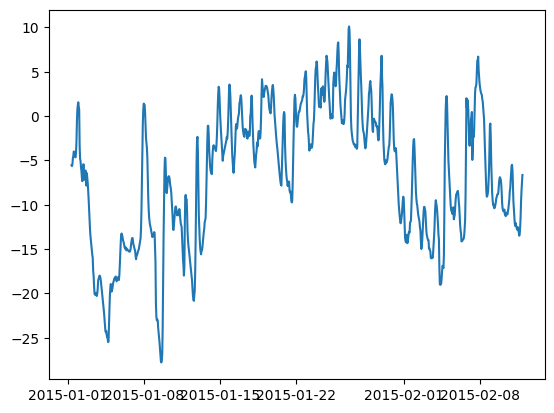

In [10]:
plt.plot(hourly_dataframe['date'].iloc[:1000],hourly_dataframe['temperature_2m'].iloc[:1000])
plt.show()